In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Download and load out dataset

### Transform Function




In [ ]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

### Transfer Learning Flower DataSet

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xvf flower_photos.tgz

--2024-09-06 15:26:35--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.1’

flower_photos.tgz.1 100%[===================>] 218.21M  20.1MB/s    in 12s     

2024-09-06 15:26:48 (17.7 MB/s) - ‘flower_photos.tgz.1’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flo

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create train and test directories
os.makedirs('flower_photos/train', exist_ok=True)
os.makedirs('flower_photos/test', exist_ok=True)

# Create subdirectories for each class in train and test directories
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
for cls in classes:
    os.makedirs(f'flower_photos/train/{cls}', exist_ok=True)
    os.makedirs(f'flower_photos/test/{cls}', exist_ok=True)


In [ ]:
# Function to move files to the respective directories
def move_files(file_list, source_dir, target_dir):
    for file in file_list:
        shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

# Loop through each class, split data, and move files
for cls in classes:
    source_dir = f'flower_photos/{cls}'
    files = os.listdir(source_dir)

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Move files to train and test directories
    move_files(train_files, source_dir, f'flower_photos/train/{cls}')
    move_files(test_files, source_dir, f'flower_photos/test/{cls}')


In [ ]:
!ls

flower_photos  flower_photos.tgz  flower_photos.tgz.1  sample_data


In [ ]:
!ls flower_photos/train/

daisy  dandelion  roses  sunflowers  tulips


In [ ]:
torch.cuda.is_available()

True

## Define Dir Structure

In [ ]:
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [ ]:
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Define Transformation

In [ ]:
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 2934
    Root location: flower_photos/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 736
    Root location: flower_photos/test/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )

#### Data Loader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

#### Visualize the data

In [ ]:
train_iter = iter(train_loader)

images, labels = next(train_iter)

In [ ]:
images = images.numpy()

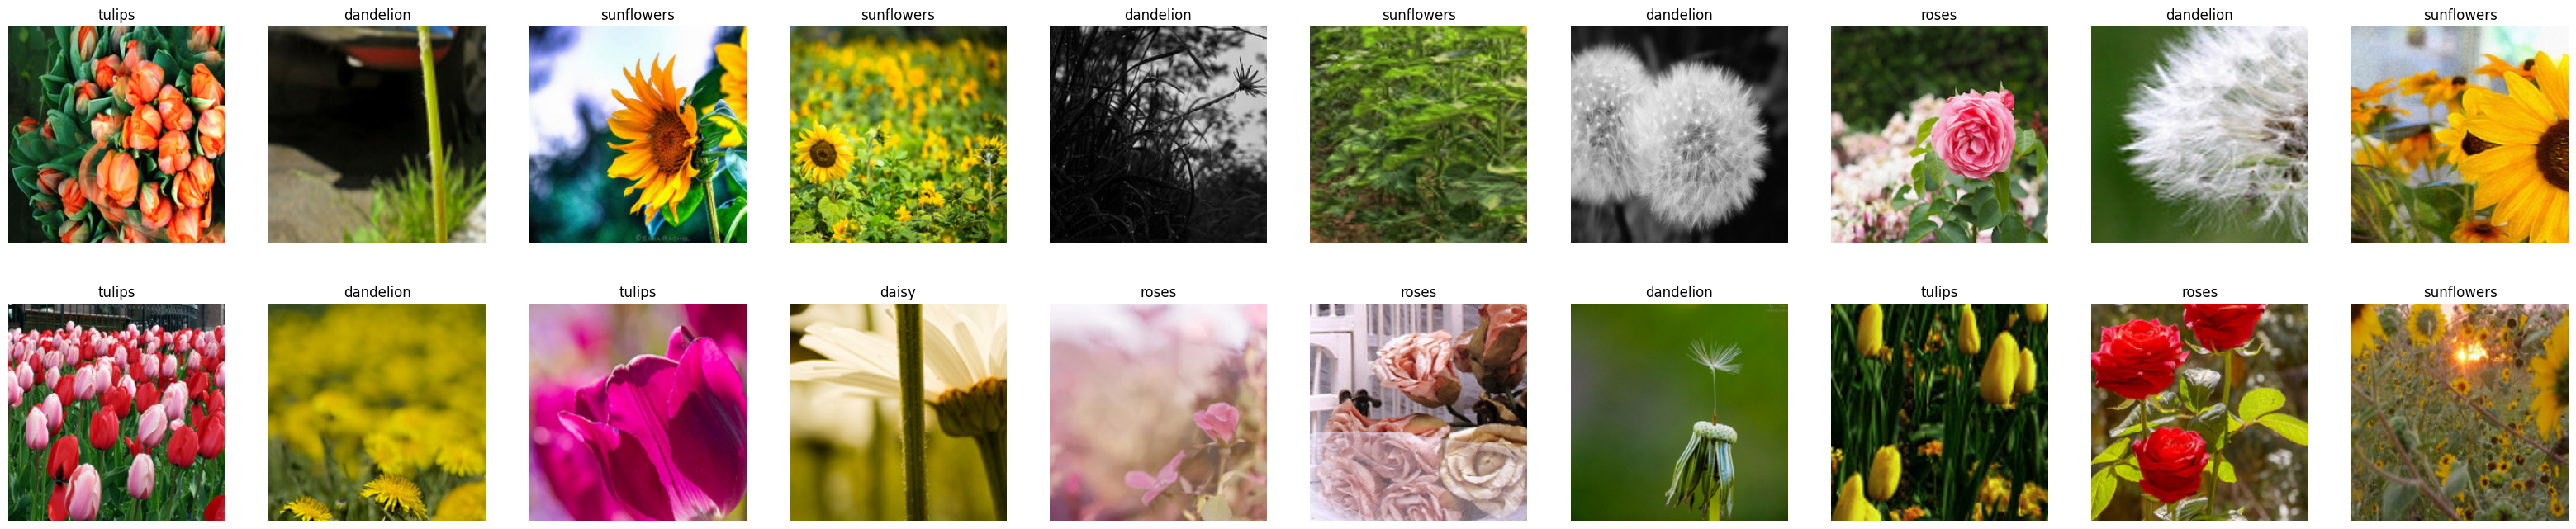

In [ ]:
fig = plt.figure(figsize=(40,8))
for id in np.arange(20):
    axis = fig.add_subplot(2, 10, id+1)
    plt.imshow(np.transpose(images[id], (1,2,0)))
    axis.set_title(classes[labels[id]])
    axis.axis('off')

# Model Define

In [ ]:
import torchvision.models as models

vgg = models.vgg16(pretrained=True)

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Add a few layers

In [ ]:
# doing this so that the model doesn't train itself from scratch
for param in vgg.features.parameters():
    param.requires_grad = False

In [ ]:
vgg.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
num_inputs = vgg.classifier[6].in_features

In [ ]:
last_fcn_layer = nn.Linear(num_inputs, len(classes))

In [ ]:
vgg.classifier[6] = last_fcn_layer

In [ ]:
vgg.classifier[6]

Linear(in_features=4096, out_features=5, bias=True)

Train the model on cuda, GPU

In [ ]:
vgg.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.001)

Training

In [ ]:
epochs = 10
for e in range(epochs):
    training_loss = 0.0
    for b_i, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = vgg(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        if b_i % 20 == 19:
            print(e, b_i+1, training_loss/20)
            training_loss = 0.0


0 20 1.6080212473869324
0 40 1.3804088592529298
0 60 1.2777974307537079
0 80 1.162007462978363
0 100 1.11072538793087
0 120 1.0115301042795182
0 140 1.0012597352266313
1 20 0.9440529316663742
1 40 0.8743957132101059
1 60 0.8609186694025993
1 80 0.8178198367357254
1 100 0.8493957608938217
1 120 0.7633515506982803
1 140 0.8030943065881729
2 20 0.7232919156551361
2 40 0.7676343470811844
2 60 0.7515005469322205
2 80 0.7524946928024292
2 100 0.7559840679168701
2 120 0.6937658965587616
2 140 0.7121212184429169
3 20 0.6941965624690056
3 40 0.6858841955661774
3 60 0.6614039465785027
3 80 0.6939184859395027
3 100 0.7045813962817192
3 120 0.622868663072586
3 140 0.6384674340486527
4 20 0.604231683909893
4 40 0.6653945058584213
4 60 0.7240960195660591
4 80 0.6345756009221077
4 100 0.604153710603714
4 120 0.6485675945878029
4 140 0.6267182767391205
5 20 0.5904525563120842
5 40 0.5512970566749573
5 60 0.6026401594281197
5 80 0.6026519611477852
5 100 0.5827601253986359
5 120 0.5588692098855972
5 140

# Test the model

In [ ]:
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
total = 0
correct = 0

for b_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = vgg(data)
    _, pred = torch.max(output, 1)
    total += target.size(0)
    correct += (pred==target).sum().item()

In [ ]:
accuracy = 100*correct/total

In [ ]:
accuracy

84.23913043478261